In [1]:
# coding=utf-8
import os
import math
import time
import joblib
import random
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from time import time
from xgboost import *
from scipy.stats import normaltest
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.ensemble import *
from sklearn.datasets import load_digits, make_hastie_10_2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# %matplotlib
# %matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 2000)

class Foo:
    def __init__(self):
        self.df = pd.read_excel('./data/Wholesale customers data.xlsx')
        self.cols = self.df.columns
        self.col_y = 'Channel'

    def get_X(self, return_dataframe=False):
        f = self.df.drop([self.col_y], axis=1)
        if return_dataframe:
            return f
        else:
            return f.to_numpy()  # original X

    def get_y(self, return_dataframe=False):
        f = self.df[self.col_y]
        if return_dataframe:
            return f
        else:
            return LabelEncoder().fit_transform(f.to_numpy())
    
    def ref_cross_validation(self, plot=False):
        X = self.get_X()
        y = self.get_y()

        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear")
        # The "accuracy" scoring shows the proportion of correct classifications

        min_features_to_select = 1  # Minimum number of features to consider
        rfecv = RFECV(
            estimator=svc,
            step=1,
            cv=StratifiedKFold(5),
            scoring="accuracy",
            min_features_to_select=min_features_to_select,
        )
        rfecv.fit(X, y)

        if plot:
            print("Optimal number of features : %d" % rfecv.n_features_)

            # Plot number of features VS. cross-validation scores
            plt.figure()
            plt.xlabel("Number of features selected")
            plt.ylabel("Cross validation score (accuracy)")
            plt.plot(
                range(min_features_to_select,
                      len(rfecv.grid_scores_) + min_features_to_select
                      ),
                rfecv.grid_scores_,
            )
            plt.show()

        opt_X = rfecv.transform(X)
        return opt_X

    def feature_scaling(self, masks=np.array([]), plot=False):
        i = 1
        self.df = foo.scaling(self.df, i, action='minmax', plot=False)
        for i, j in enumerate(foo.cols):
            if np.isin(i, masks, invert=False):  # not in
                continue
            if i >= 2:
                self.df = foo.scaling(self.df, i, action='log', plot=False)
                self.df = foo.scaling(self.df, i, action='minmax', plot=False)
        if plot:
            for i, j in enumerate(foo.cols):
                self.scaling(self.df, i, plot=True)
    
    def scaling(self, f, col_idx, action=None, plot=False):
        c = f.columns[col_idx]
        tmp = f[[c]]
        if action == 'log':
            tmp = np.log(tmp + 1)
            color = 'r'
        elif action == 'minmax':
            tmp = MinMaxScaler().fit_transform(tmp)
            color = 'g'
        elif action == 'standard':
            tmp = StandardScaler().fit_transform(tmp)
            color = 'b'
        else:
            color = 'k'

        if plot:
            plt.figure(figsize=(7, 2), dpi=70)
            sns.distplot(tmp, kde=True, color=color)
            plt.title("\"%s\" scaling:%s, (min:%.2f, max:%.2f)" % (c, action, tmp.min(), tmp.max()))
            plt.show()
        f[c] = tmp
        return f

    @staticmethod
    def clustering_kmeans(df, n=1):
        return KMeans(n_clusters=n, init='random', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=0,
                      copy_x=True, algorithm='full').fit(df).labels_

    def clustering_mean_shift(self):
        bandwidth = estimate_bandwidth(self.df, quantile=0.2, n_samples=500)
        return MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(self.df).labels_

    def clustering_Hierarchical_Clustering(self):
        # 'ward', 'average', 'complete', 'single'
        return AgglomerativeClustering(linkage='single', n_clusters=6).fit(self.df).labels_

    def outlier_removal(self, x, labels, protected_labels=np.array([]), outliers_fraction=0.01, plot=False):
        r = random.randint(1, 10000)
#         if plot:
#             print("random_state=%d" % r)
        clf = IsolationForest(random_state=9398, max_samples=0.99, bootstrap=False, n_estimators=250, contamination=outliers_fraction)
        tmpdf = x.copy(deep=True)
        tmpdf['result'] = clf.fit_predict(x)
        tmpdf.loc[(tmpdf['result'] == -1) & (tmpdf[self.col_y].isin(protected_labels)), 'result'] = 1

        if plot:
#             f = np.mean(clf.score_samples(x))
#             print("\nscorer_f : %.6f, rand_seed: %d" % (f, r))
            x = PCA().fit_transform(x)
            indices_norm = tmpdf[tmpdf['result'] == 1].index
            indices_iso = tmpdf[tmpdf['result'] == -1].index
            x1 = np.delete(x, indices_iso, axis=0)
            x2 = np.delete(x, indices_norm, axis=0)
            c1 = np.delete(labels, indices_iso)

            _, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax = plt.axes(projection='3d', elev=30, azim=60)
            ax.scatter3D(x1[:, 0], x1[:, 1], x1[:, 2], c=c1, cmap=plt.cm.Set1, edgecolor="k", s=40, alpha=.9, )
            ax.scatter3D(x2[:, 0], x2[:, 1], x2[:, 2], color='r', marker='x', edgecolor="k", s=40, alpha=.9, )
            ax.set_title("Visualizations on the first three PCA directions")
            ax.set_xlabel("1st eigenvector")
            ax.w_xaxis.set_ticklabels([])
            ax.set_ylabel("2nd eigenvector")
            ax.w_yaxis.set_ticklabels([])
            ax.set_zlabel("3rd eigenvector")
            ax.w_zaxis.set_ticklabels([])
            plt.show()
        return tmpdf.drop(tmpdf[(tmpdf['result'] == -1)].index, axis=0).drop(['result'], axis=1).reset_index(drop=True)

    @staticmethod
    def pca_plot(x, labels, figsize=(8, 8), elev=30, azim=60):
        x = PCA().fit_transform(x)
        _, ax = plt.subplots(1, 1, figsize=figsize)
        ax = plt.axes(projection='3d', elev=elev, azim=azim)
        ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], c=labels, cmap=plt.cm.Set1, edgecolor="k", s=40, alpha=.9, )
        ax.set_title("Visualizations on the first three PCA directions")
        ax.set_xlabel("1st eigenvector")
        ax.w_xaxis.set_ticklabels([])
        ax.set_ylabel("2nd eigenvector")
        ax.w_yaxis.set_ticklabels([])
        ax.set_zlabel("3rd eigenvector")
        ax.w_zaxis.set_ticklabels([])
        plt.show()

if __name__ == '__main__':
    foo = Foo()

# 1.Exploratory Data Analyze

- Perform EDA and any data cleaning if necessary.

In [2]:
foo.df.isnull().any()

Channel             False
Region              False
Fresh               False
Milk                False
Grocery             False
Frozen              False
Detergents_Paper    False
Delicassen          False
dtype: bool

<AxesSubplot:>

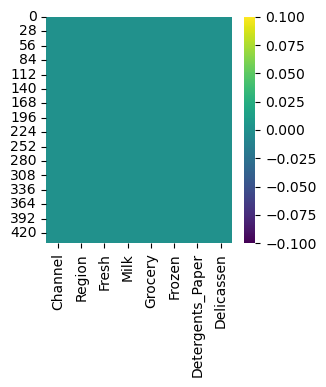

In [3]:
plt.figure(figsize=(3, 3), dpi=100)
sns.heatmap(foo.df.isnull(), cmap="viridis")

In [4]:
foo.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
foo.df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [6]:
foo.df.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. feature scaling

- Implement Feature Scaling to Normalize the data(compare the histogram/KDE for MinMaxScaler
and StandardScaler). Choose one of the Scaler to proceed ahead and provide reasoning as to
why it was selected?

## 2.1. visualization on feature distributions

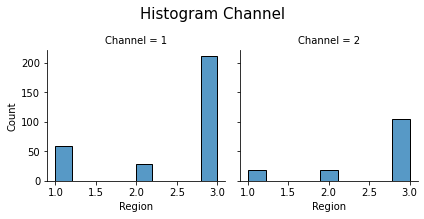

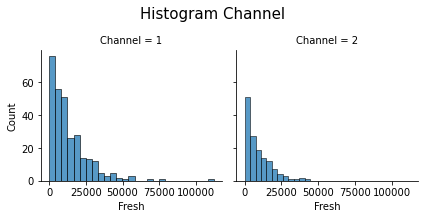

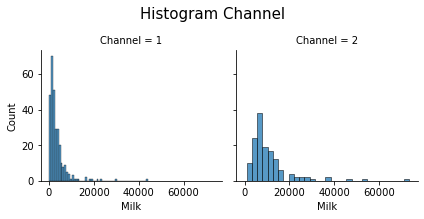

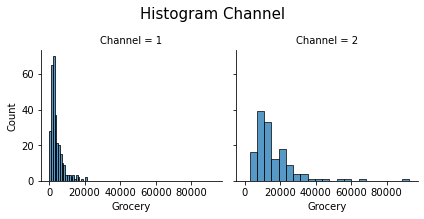

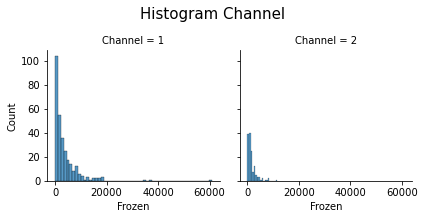

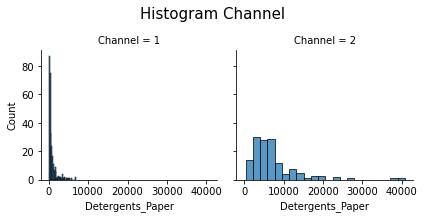

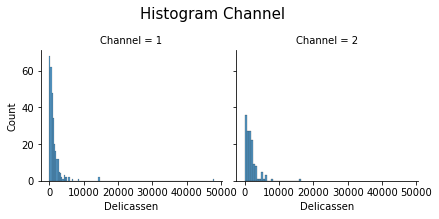

In [7]:
cat = foo.df.columns[0]
for i,col in enumerate(foo.cols):
    if i>0:
        disp = foo.df.columns[i]
        tmp = foo.df[[cat, disp]]
        g = sns.FacetGrid(tmp, col=cat, margin_titles=True)
        g.map(sns.histplot, disp)
        g.figure.subplots_adjust(top=.8)
        g.fig.suptitle("Histogram %s" % cat, y=1, size=15)

## 2.2. visualization by PairGrid

Text(0.5, 0.99, 'distributions on features')

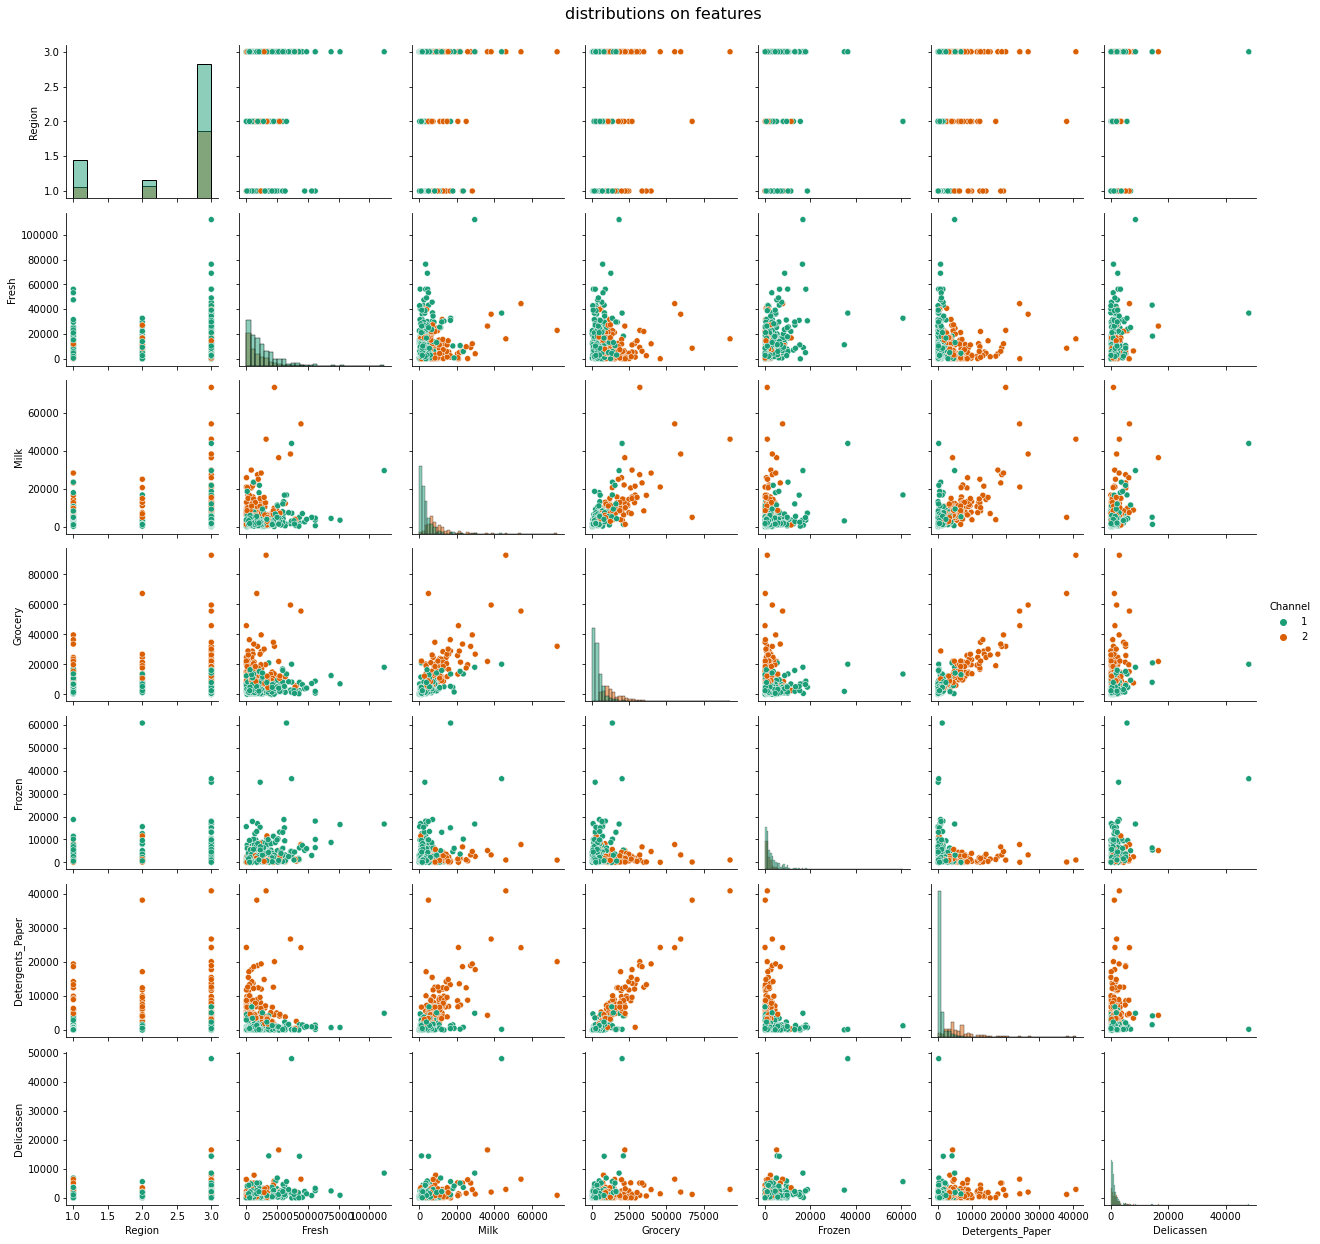

In [8]:
g = sns.PairGrid(foo.df, hue=foo.cols[0], palette="Dark2")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
g.figure.subplots_adjust(top=.96)
g.fig.suptitle("distributions on features", y=0.99, size=16)

## 2.3. feature scaling

### 2.3.1. training data distribution before scaling

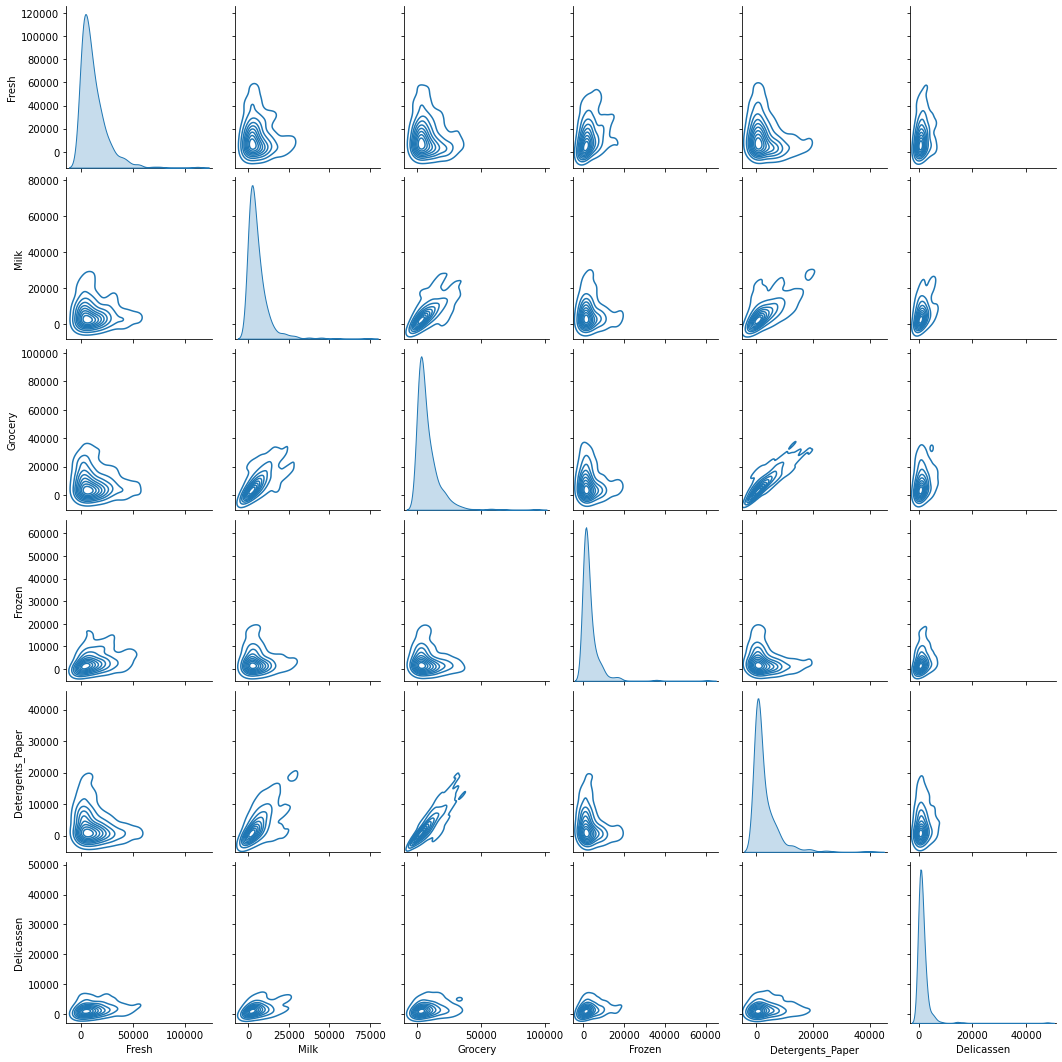

In [9]:
sns.pairplot(foo.df.drop(['Channel','Region'], axis=1), kind="kde")

### 2.3.2. scaling

***

Different features always have different data scales and distributions. An extreme skewed data distribution will brings negative performance on model training. To give equal importance to all features, we need to scale the continuous features. Applying normalization technics will bring a positive effect on gradient decent computing and model training performance. 

`log(x+1) scaling` mapping the raw data distribution to a less skewed distribution, but will not change the monotonicity of raw data distribution.

`minmax scaling` will promise an non-negative data distribution for future computing.

`standard scaling` makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance.

For example, for feature 'Fresh':
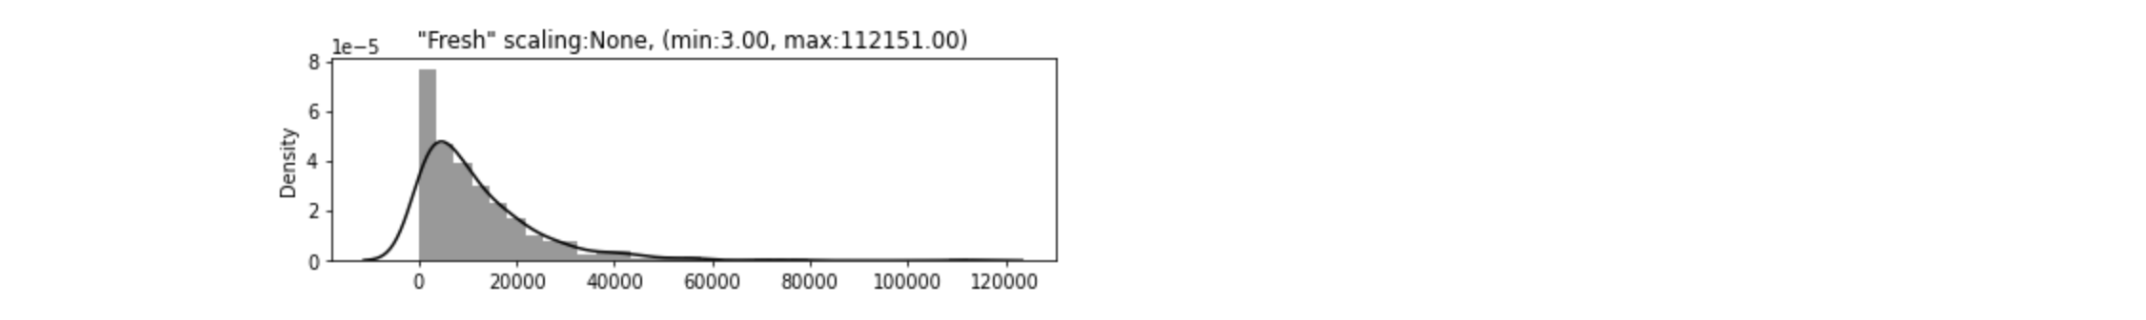

This is `standard scaling`:
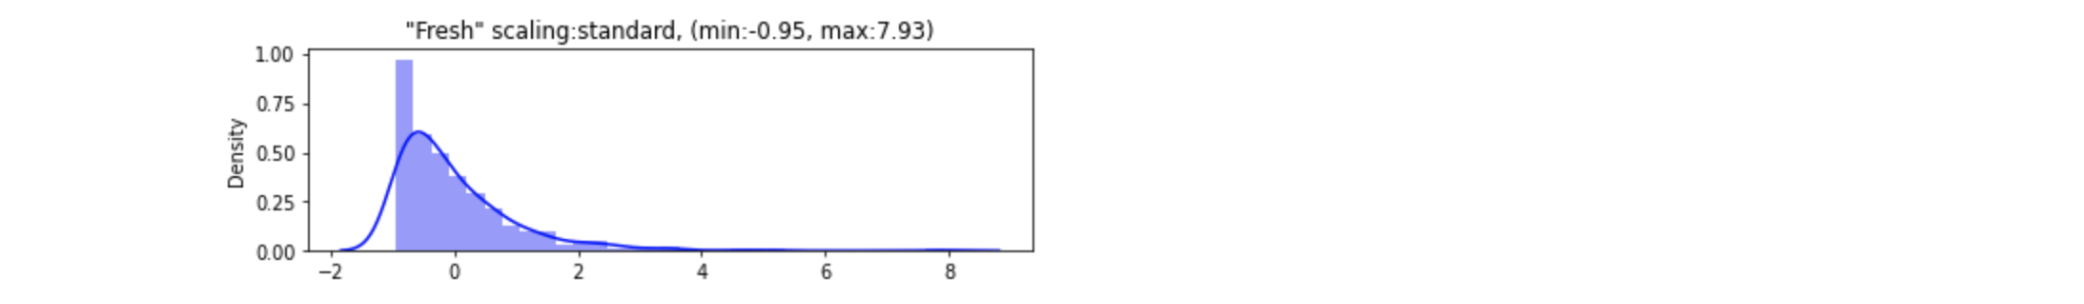

This is `minmax scaling`:
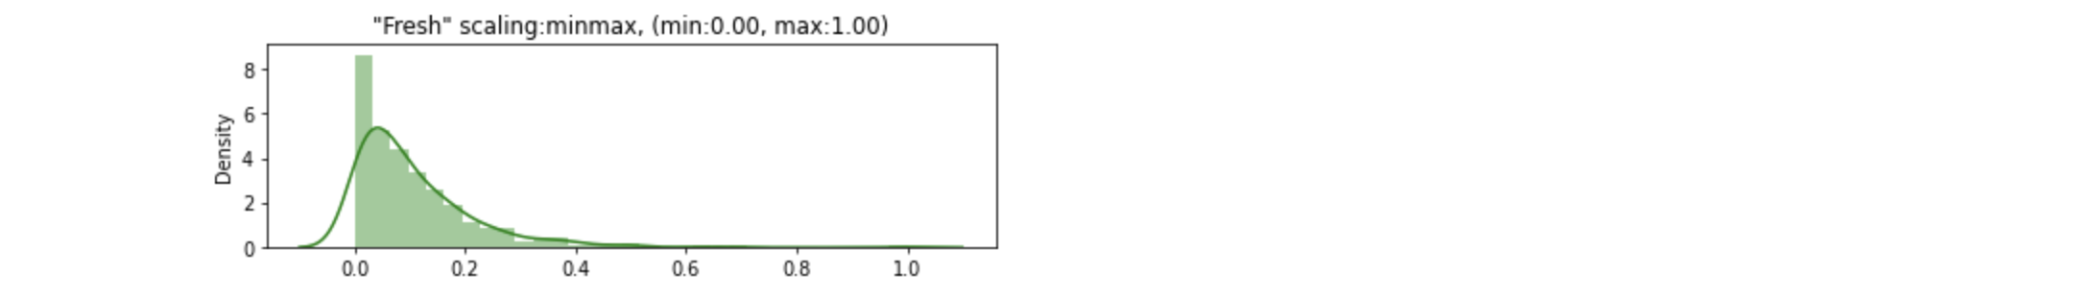

This is `log scaling`:
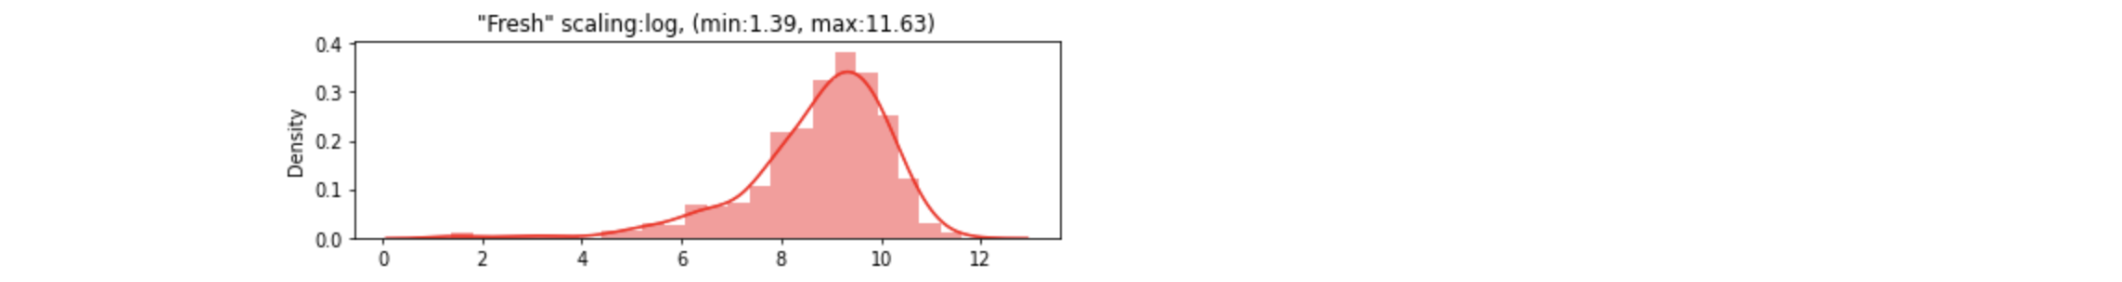

***

### 2.3.1. scaling the features

Applying minmaxscaler to scale the features

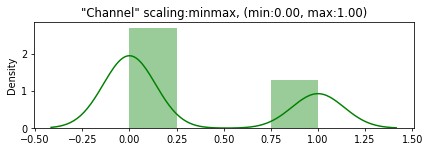

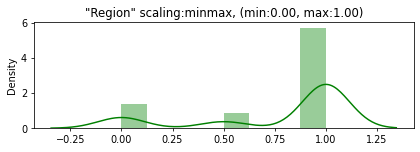

In [10]:
df = Foo().df
i=0
df = foo.scaling(df, i, action='minmax', plot=True)
i=1
df = foo.scaling(df, i, action='minmax', plot=True)

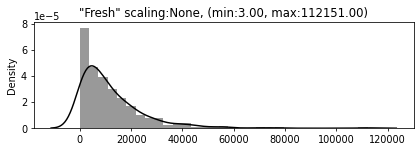

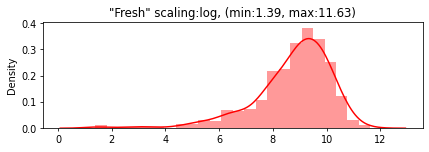

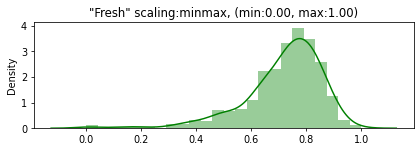

In [11]:
# applying log norm, then minmax norm

i=2
df = foo.scaling(df, i, action=None, plot=True)
df = foo.scaling(df, i, action='log', plot=True)
df = foo.scaling(df, i, action='minmax', plot=True)

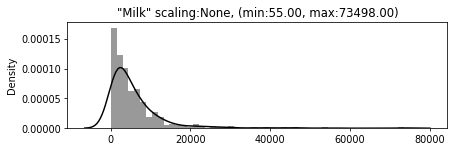

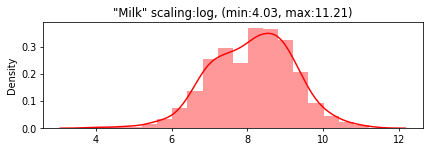

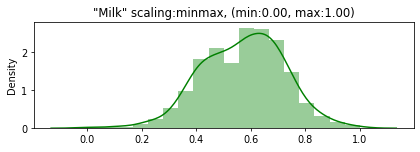

In [12]:
# applying log norm, then minmax norm

i=3
df = foo.scaling(df, i, action=None, plot=True)
df = foo.scaling(df, i, action='log', plot=True)
df = foo.scaling(df, i, action='minmax', plot=True)

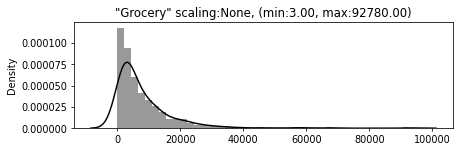

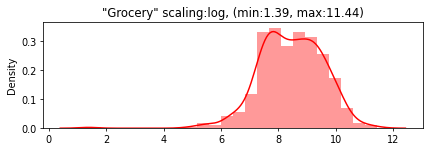

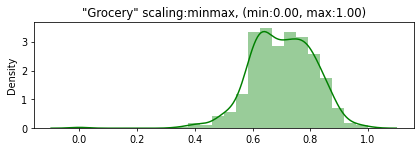

In [13]:
# applying log norm, then minmax norm

i=4
df = foo.scaling(df, i, action=None, plot=True)
df = foo.scaling(df, i, action='log', plot=True)
df = foo.scaling(df, i, action='minmax', plot=True)

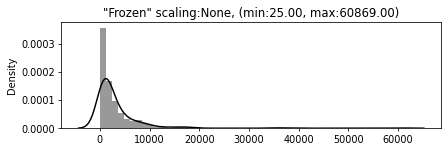

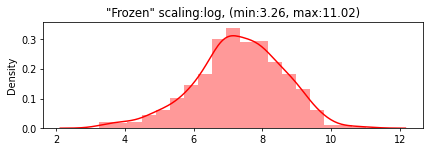

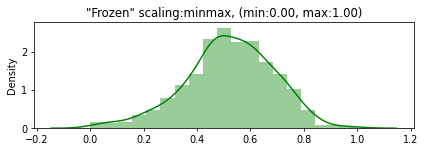

In [14]:
# applying log norm, then minmax norm

i=5
df = foo.scaling(df, i, action=None, plot=True)
df = foo.scaling(df, i, action='log', plot=True)
df = foo.scaling(df, i, action='minmax', plot=True)

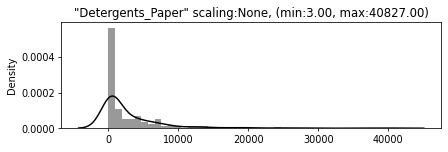

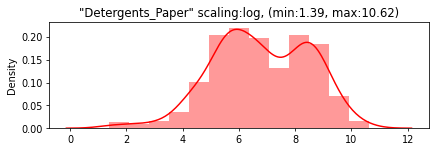

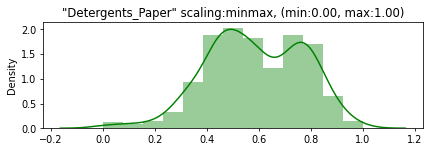

In [15]:
# applying log norm, then minmax norm

i=6
df = foo.scaling(df, i, action=None, plot=True)
df = foo.scaling(df, i, action='log', plot=True)
df = foo.scaling(df, i, action='minmax', plot=True)

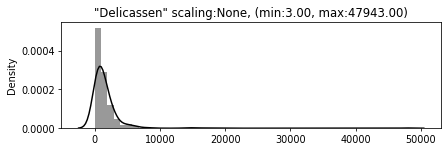

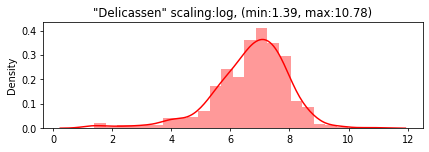

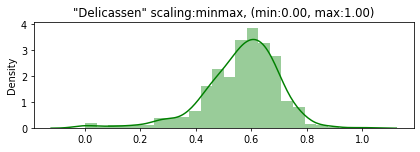

In [16]:
# applying log norm, then minmax norm

i=7
df = foo.scaling(df, i, action=None, plot=True)
df = foo.scaling(df, i, action='log', plot=True)
df = foo.scaling(df, i, action='minmax', plot=True)

### 2.3.3. training data distribution after scaling

***

compare this kde pairplot to the previous one, we got a less skewed dataset.

***

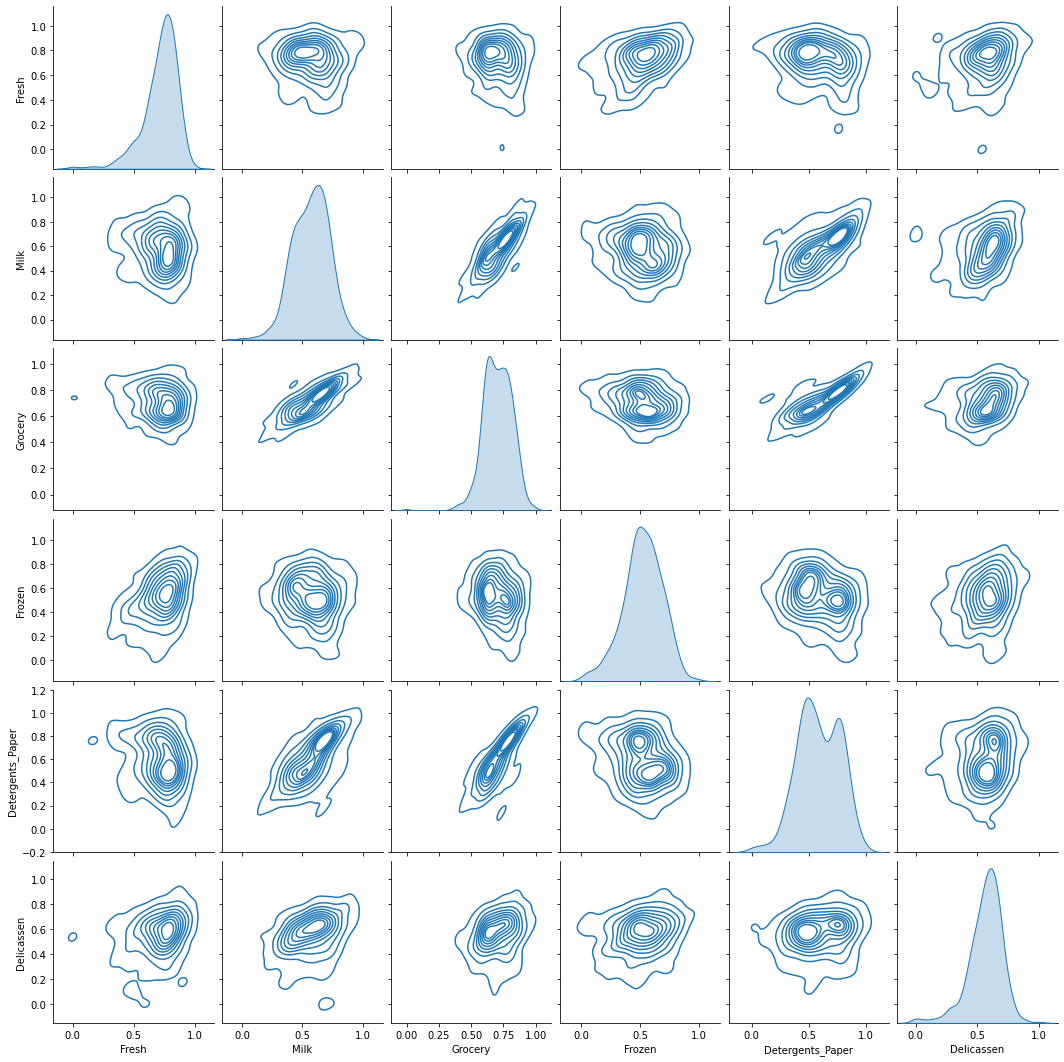

In [17]:
sns.pairplot(df.drop(['Channel','Region'], axis=1), kind="kde")

### 2.3.4. outlier removal

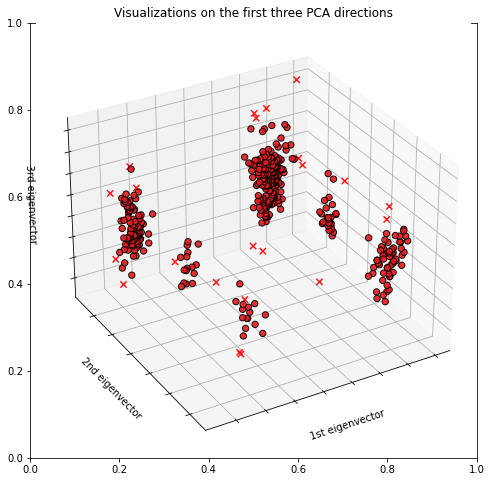

In [18]:
foo = Foo()
foo.feature_scaling(plot=False)
df = foo.df
c = [1] * df.shape[0]
df = foo.outlier_removal(df, c, protected_labels=np.array([]), outliers_fraction=0.05, plot=True)

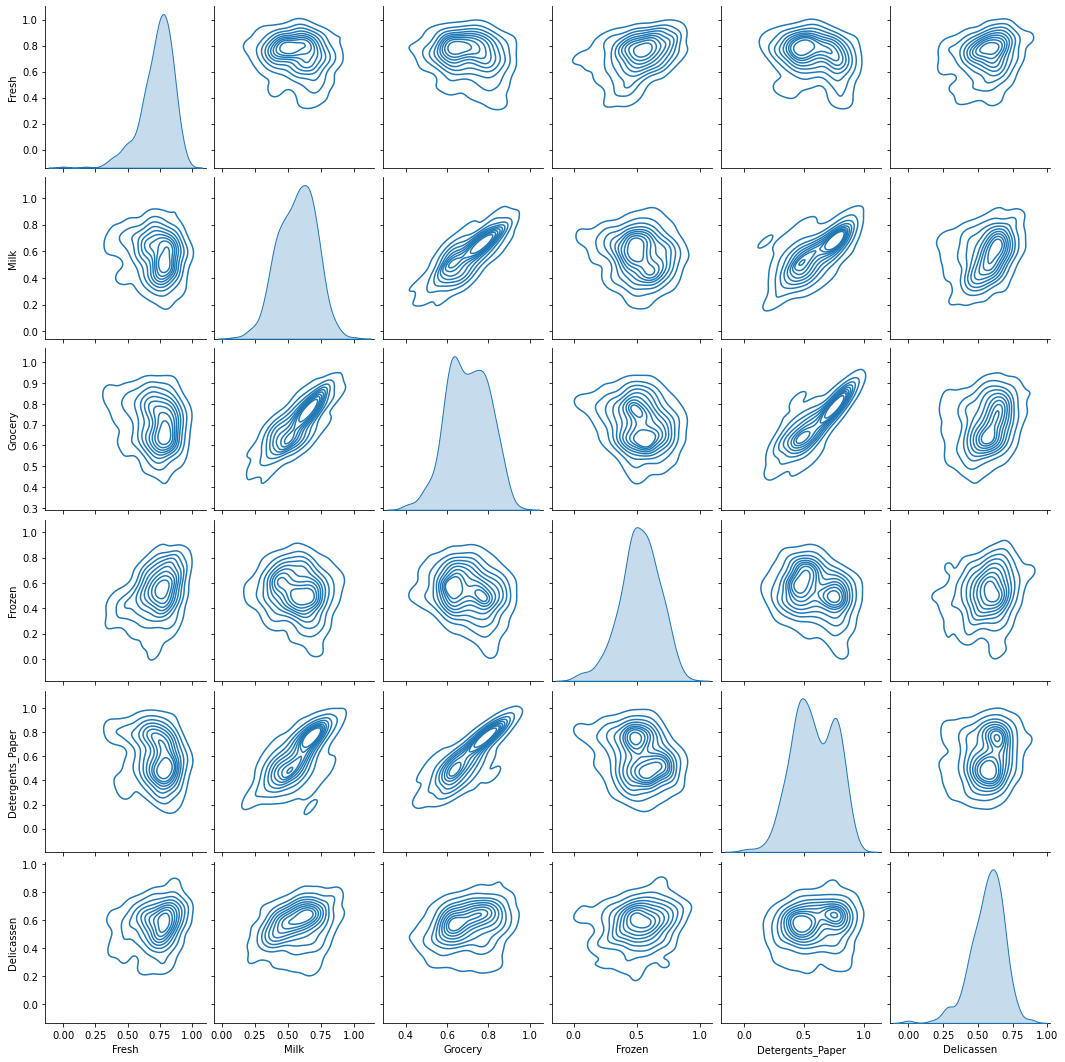

In [19]:
sns.pairplot(df.drop(['Channel','Region'], axis=1), kind="kde")

# 3. Feature selection

- Find optimal number of features using RFECV and show the plot between Number of features selected vs Cross validation score (use channel as target variable)

## 3.1. prepare dataset

In [20]:
# reset data
foo = Foo()
foo.feature_scaling(plot=False)

## 3.2. Applying RFE Cross Validation

In [21]:
X = foo.get_X()
y = foo.get_y()

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

rfecv.support_, rfecv.ranking_

(array([False, False,  True,  True,  True,  True, False]),
 array([2, 3, 1, 1, 1, 1, 4]))

## 3.3. Plot relationships between number of features selected vs cross validation score

***

`As shown on the plot below, optimized to 4 features gain the highest cv score on average.`

***

Optimal number of features : 4


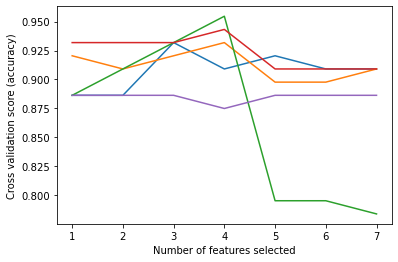

In [22]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, 
          len(rfecv.grid_scores_) + min_features_to_select
         ),
    rfecv.grid_scores_,
)
plt.show()

## 3.4. Store optimised X

In [23]:
opt_X = rfecv.transform(X)
opt_X

array([[0.71731469, 0.75057896, 0.2722909 , 0.70474822],
       [0.71951829, 0.77399718, 0.54349816, 0.72729801],
       [0.7045134 , 0.75218413, 0.58357713, 0.73439441],
       ...,
       [0.78311809, 0.88848217, 0.36400839, 0.89037744],
       [0.49675087, 0.62922741, 0.47534515, 0.40555451],
       [0.47529216, 0.64090056, 0.12007093, 0.51818925]])

# 4. Implement KMeans Clustering 

- Implement KMeans Clustering for K=2 to K=15 and based on elbow method identify what is the optimum number of clusters

***

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre. As clusters number k increases, the sum of squared distance tends to zero. And the inflection point of the elbow plot is the optimal k we should select.

As the example shows in this figure, the inflection point on the curve is he optimal number of k-means clusters.

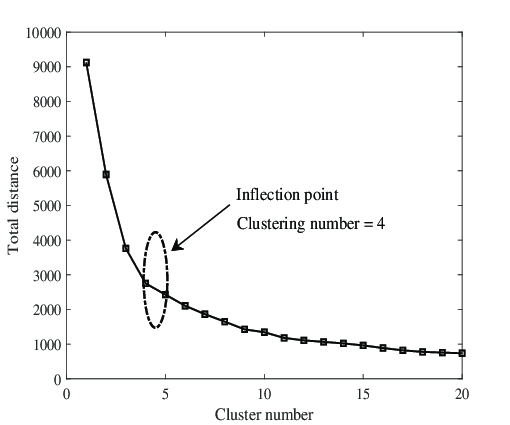

`The optimal cluster number is 4 due to the observation on elbow plot below.`

***

In [24]:
# prepare data
foo = Foo()
foo.feature_scaling(plot=False)
df = foo.df
c = [1] * df.shape[0]
df = foo.outlier_removal(df, c, protected_labels=np.array([]), outliers_fraction=0.05, plot=False)
df.shape

(418, 8)

The optimal cluster number is **4** due to the observation on elbow plot.


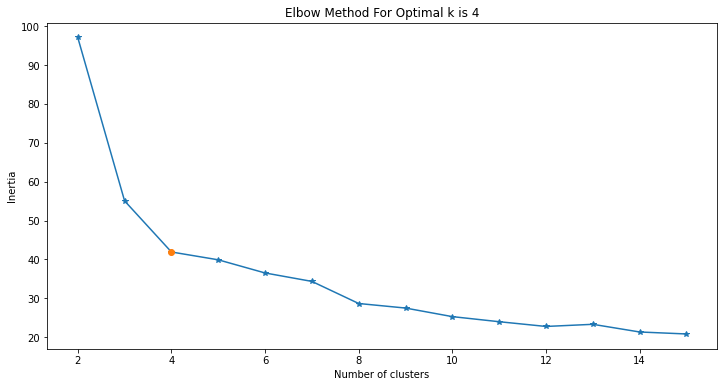

In [25]:
SSE = []
for i in range(2,16):
    kmeans = MiniBatchKMeans(n_clusters = i, random_state=8189).fit(df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(2,16), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker="*")
plt.plot(frame['Cluster'][2], frame['SSE'][2], marker="o")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k is 4')

print("The optimal cluster number is **4** due to the observation on elbow plot.")

# 5. Implement PCA

- Implement PCA with number of original features to answer how much variance is explained by first 2 components and by first 4 components and visualize the clusters in the data

***

`82.98% variance is explained by first 2 components`

`93.13% variance is explained by first 4 components`

***

In [26]:
# prepare data
foo = Foo()
foo.feature_scaling(plot=False)
df = foo.df
c = [1] * df.shape[0]
df = foo.outlier_removal(df, c, protected_labels=np.array([]), outliers_fraction=0.05, plot=False)
df.shape

(418, 8)

In [27]:
pca = PCA().fit(df)
X_reduced = pca.transform(df)
pca.singular_values_, pca.explained_variance_ratio_

(array([10.2809351 ,  7.80880571,  3.44308682,  2.92530011,  2.31367749,
         2.14903285,  1.7056405 ,  0.94802207]),
 array([0.52620781, 0.3035717 , 0.05901848, 0.04260229, 0.02665003,
        0.02299207, 0.01448328, 0.00447434]))

## 5.1. calculate explained variance ratio

In [28]:
i=2
print("%.2f%% variance is explained by first %d components" % (np.sum(pca.explained_variance_ratio_[:i])*100, i))

82.98% variance is explained by first 2 components


In [29]:
i=4
print("%.2f%% variance is explained by first %d components" % (np.sum(pca.explained_variance_ratio_[:i])*100, i))

93.14% variance is explained by first 4 components


## 5.2. visualization by PCA

***

Applying optimal number of clusters to re-calculate the KMeans clustering labels. 

Applying PCA to visualizing the data set using the top 3 components.

***

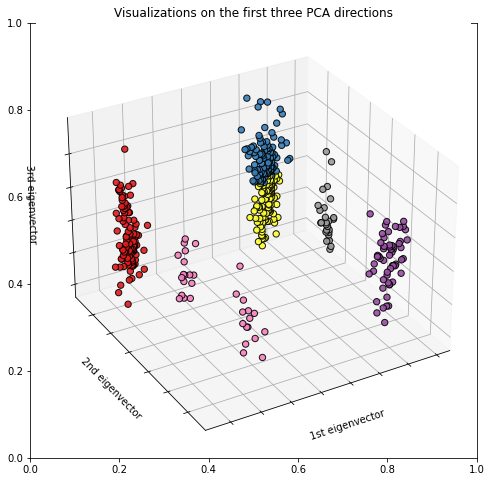

In [30]:
i = 6
kmeans = KMeans(n_clusters = i, init='random', 
                n_init=10, max_iter=300, tol=0.0001,
                verbose=0, random_state=0, 
                copy_x=True, algorithm='full').fit(df) 

X_reduced = PCA().fit_transform(df)

_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plt.axes(projection='3d', elev=30, azim=60)
ax.scatter3D(X_reduced[:, 0], 
             X_reduced[:, 1], 
             X_reduced[:, 2],
             c=kmeans.labels_, 
             cmap=plt.cm.Set1,
             edgecolor="k",
             s=40,
             alpha=.9
            )
ax.set_title("Visualizations on the first three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

# 6. XGBoost Classifier

- Implement XGBoost Classifier with 5 Fold CV and report the performance metrics (precision, recall, and accuracy)

- Provide observations and reasoning for visualizations and results included

In [31]:
# prepare data
foo = Foo()
foo.feature_scaling(plot=False)
# c = [1] * df.shape[0]
# foo.df = foo.outlier_removal(foo.df, c, protected_labels=np.array([]), outliers_fraction=0.1, plot=False)
dfx = foo.get_X(return_dataframe=False)
dfy = foo.get_y(return_dataframe=False)
df = foo.df

model = XGBClassifier()
params = {
    "learning_rate": np.arange(0, 1.1, 0.1),
    "max_depth": np.arange(1, 9, 2),
    "min_child_weight": range(1, 10),
    "gamma": np.arange(0, 1.1, 0.2),
    "colsample_bytree": np.arange(0.1, 1.1, 0.1),
    "n_estimators": np.arange(20, 250, 40)
}
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "mean_absolute_error": make_scorer(mean_absolute_error),
    "mean_squared_error": make_scorer(mean_squared_error),
    "r2_score": make_scorer(r2_score),
}

## 6.1. Precision, Recall, and Accuracy

In [32]:
X_modeling, X_test, y_modeling, y_test = train_test_split(dfx, dfy, test_size=0.1, random_state=999, stratify=dfy)
# best_params = {'n_estimators': 60,
#  'min_child_weight': 5,
#  'max_depth': 5,
#  'learning_rate': 0.1,
#  'gamma': 0.4,
#  'colsample_bytree': 0.9}
gs = RandomizedSearchCV(XGBClassifier(), params, cv=5, verbose=0, scoring=scoring, 
                        refit=list(scoring.items())[0][0], return_train_score=True, )
gs.fit(X_modeling, y_modeling, eval_metric='rmse')

start = time()
y_pred = gs.predict(X_test)
cost = (time() - start) * 1000
print("precision_score    : %.3f" % precision_score(y_test, y_pred))
print("recall_score       : %.3f" % recall_score(y_test, y_pred))
print("accuracy_score     : %.3f" % accuracy_score(y_test, y_pred))
print("latency            : %.3f ms" % cost)

precision_score    : 0.857
recall_score       : 0.857
accuracy_score     : 0.909
latency            : 1.822 ms


In [33]:
gs.best_params_

{'n_estimators': 140,
 'min_child_weight': 4,
 'max_depth': 1,
 'learning_rate': 0.7000000000000001,
 'gamma': 0.6000000000000001,
 'colsample_bytree': 0.8}

## 6.2. Confusion matrix

***

The precision score is 0.857, recall score is 0.857, and accuracy score is 0.909.

The model has a good performance to classify the channels of customer with these features. 

***

<AxesSubplot:>

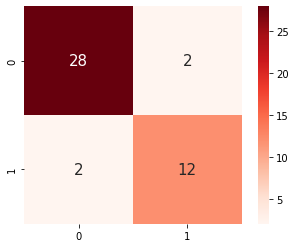

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = 'Reds', annot_kws = {'size': 15}, 
            square = True, fmt = '.0f')

## 7. Conclusion

Provide observations and reasoning for visualizations and results included

## 7.1. thinking on feature Region

The research on Data Mining of Customer Segmentation in Customer Relationship Management aims to mine the relationships and similarities between customers. But different regions are logically not geographical, populous or economical equidistance if we considered it as a relasionship clustering problem. This dataset is not good enough for Customer Segmentation.

## 7.2. thinking on cluster model K-means

As the figure shows below, although the first 2 components explains more than 80% of the variance of this dataset, k-means is not able to identify all the clusters, considering those small ones as a whole and separating the bigger one as two.

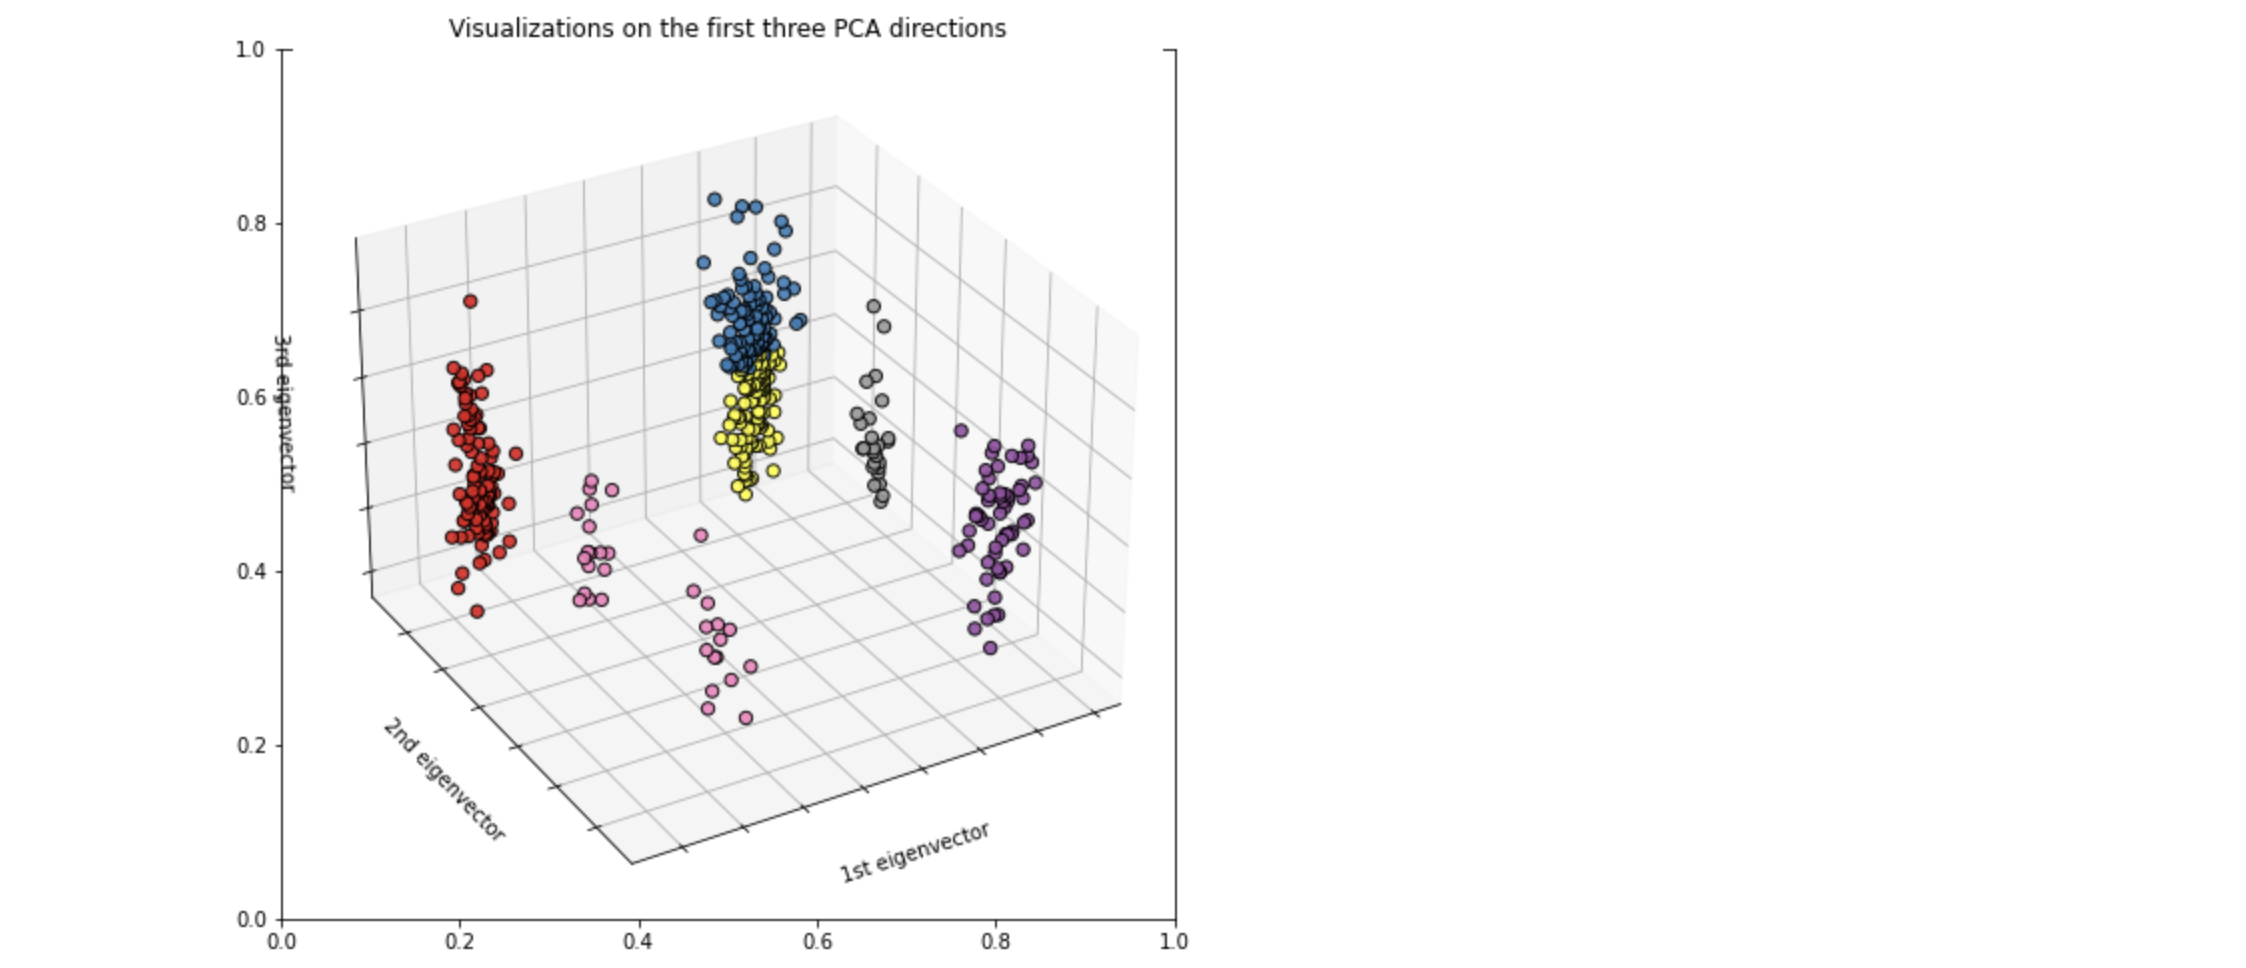

I think there are two main reasons:
1. Skewed clusters. Some clusters are much bigger than the others.
2. Distributions. Outliers has negative effects on k-means accuracy.

As a result, **Hierarchical Clustering** works better on this dataset.


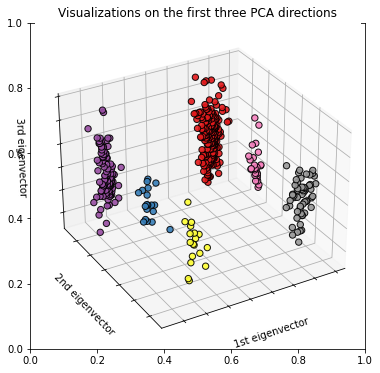

In [35]:
foo = Foo()
foo.feature_scaling(plot=False)
c = foo.clustering_kmeans(foo.df)
foo.df = foo.outlier_removal(foo.df, c, protected_labels=np.array([2]), outliers_fraction=0.05, plot=False)

# Hierarchical_Clustering
labels = foo.clustering_Hierarchical_Clustering()
foo.pca_plot(foo.df, labels, (6,6), 30, 60)

## 7.3. thinking on normalization

K-means will not work well on raw dataset in most of case because of un-normalized feature scales.

K-means will perform a better result on scaling data.

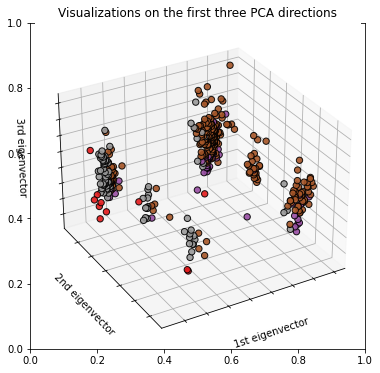

In [36]:
foo = Foo()
labels = foo.clustering_kmeans(foo.df, 4)  # clustering on the raw dataset

foo.feature_scaling(plot=False)  # then apply scaling for plot
foo.pca_plot(foo.df, labels, (6,6), 30, 60)

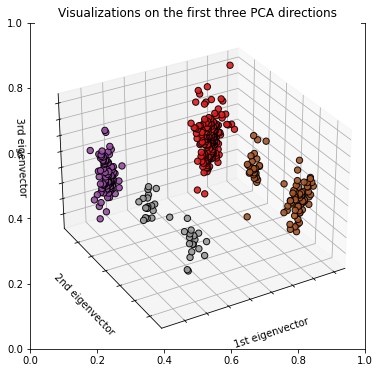

In [37]:
foo = Foo()
foo.feature_scaling(plot=False)  # then scaling for plot

labels = foo.clustering_kmeans(foo.df, 4)  # clustering first
foo.pca_plot(foo.df, labels, (6,6), 30, 60)